In [1]:
!pip install innvestigate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 KB 1.4 MB/s eta 0:00:00


In [7]:
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
datapath = '/content/drive/My Drive/data/NIH/'

Mounted at /content/drive


In [4]:
import argparse
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from skimage.metrics import structural_similarity as compare_ssim
from scipy.spatial.distance import euclidean 
import numpy as np
from keras.models import load_model
from keras.applications.densenet import preprocess_input
import keras.backend as K
import tensorflow as tf
import cv2
from innvestigate import create_analyzer

# parser = argparse.ArgumentParser(description="Arguments to run the script.")

# parser.add_argument(
#     "--method", type=str, default="cnn", help="Which method do you want to evaluate?"
# )

# parser.add_argument(
#     "--top", type=int, default=4, help="Number of images to consider for precision?"
# )

# parser.add_argument(
#     "--split", type=int, default=1, help="Do you want to compute results for which split?"
# )

# args = parser.parse_args()
args_top = 10
args_split = 1
args_method = "cnn"


re_img = []
re_label = []


def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)



# Define percentage of data that goes into catalogue
if(args_top)==4: 
    split_size=0.055
    # split_size = 0.9
if(args_top)==7:
    split_size=0.115
if(args_top)==10:
    split_size=0.175    


#Vector that defines seed based on split
random_seeds = [42,1,27,57,77]


#Load validation images, and labels
with open(datapath+"validation_pleural_images_2.pickle",'rb') as fp: 
        val_imgs = pickle.load(fp)
with open(datapath+"validation_pleural_labels_2.pickle",'rb') as fp: 
        val_labels = pickle.load(fp)
with open(datapath+"validation_pleural_path_names_2.pickle",'rb') as fp: 
        val_path = pickle.load(fp)    
        
print("??", len(val_imgs))

#Split data into test (validation) and catalogue
img_val, img_catalog, label_val, label_catalog = \
train_test_split(val_imgs, val_labels, stratify=val_labels, test_size=split_size, \
                 random_state=random_seeds[args_split-1])

print("!!!!", len(img_val))

path_val, path_catalog, _, _ = \
train_test_split(val_path, val_labels, stratify=val_labels, test_size=split_size, \
                 random_state=random_seeds[args_split-1])


#Select image from the test set
for z in range(len(img_val)):         
    if(label_val[z]==1): 
        img_test = img_val[z]
        label_test = label_val[z]
        path_test = path_val[z]

print("test_image:", path_test)

if(args_method=="ssim"):
    dist = [] 
    index = [] 
    
    # For all image in catalog compute distance to test_image
    for n in range(len(img_catalog)): 
        index.append(n) # append index to do the retrieval afterwards 
        dist.append(compare_ssim(img_test, img_catalog[n]))
    
    index = np.asarray(index)
    index = np.reshape(index, (index.shape[0], 1))
    dist = np.asarray(dist)
    dist = np.reshape(dist, (dist.shape[0], 1))
    
    results = np.concatenate([index, dist], axis=1)
    
    #high values mean high similarity 
    results = results[results[:,1].argsort()[::-1]] 
    
    count = 0     
    for j in range(args_top): 
        if(label_catalog[int(results[j,0])]==1):
            count+=1
        
    print('Precision for split-' + str(args_split) + ' and top-' + \
          str(args_top) + ': ', count/args_top)

if(args_method=="cnn"): 
    model = load_model(datapath+'Model/pleural_dense_AP.hdf5', \
                   custom_objects={"auroc": auroc})
    
    def pre_process_image(image): 
        image = cv2.resize(image, (224,224))
        image = np.reshape(image, (224,224,1))
        image = np.concatenate([image, image, image], axis=2)
        image = np.reshape(image, (1,224,224,3))
        image = preprocess_input(image)    
        
        return image

    img_test = pre_process_image(img_test)    
    get_penultimate_output = K.function([model.layers[0].input],\
                                        [model.layers[-2].output])
    
    l_out = get_penultimate_output([img_test])[0]
    
    l_out = [item for sublist in l_out for item in sublist]

    def l2_embedding_distance(l_test, img): 
        img = pre_process_image(img)
        emb = get_penultimate_output([img])[0]
        emb = [item for sublist in emb for item in sublist]
        dist = euclidean(l_test, emb)
        
        return dist
    
    dist = [] 
    index = [] 
    
    # For all image in catalog compute distance to test_image
    for n in range(len(img_catalog)): 
        index.append(n) # append index to do the retrieval afterwards 
        dist.append(l2_embedding_distance(l_out, img_catalog[n]))
        #print(dist)   
    
    index = np.asarray(index)
    index = np.reshape(index, (index.shape[0], 1))
    dist = np.asarray(dist)
    dist = np.reshape(dist, (dist.shape[0], 1))
        
    results = np.concatenate([index, dist], axis=1)
    
    
    results = results[results[:,1].argsort()] 
    print(results)
    
    count=0
    
    for j in range(args_top): 
        re_img.append(path_catalog[int(results[j,0])])
        re_label.append(label_catalog[int(results[j,0])])
        if(label_catalog[int(results[j,0])]==1):
            count+=1
    print("??????", count)
        
    print('Precision for split-' + str(args_split) + ' and top-' + \
          str(args_top) + ': ', count/args_top)
    
    
if(args_method=="igcbir"): 
    clf_model=load_model(datapath+'Model/pleural_dense_AP.hdf5', \
                   custom_objects={"auroc": auroc})
    
    int_model=load_model(datapath+'Model/pleural_interpret.hdf5')
    
    def pre_process_image(image): 
        image = cv2.resize(image, (224,224))
        image = np.reshape(image, (224,224,1))
        image = np.concatenate([image, image, image], axis=2)
        image = np.reshape(image, (1,224,224,3))
        image = preprocess_input(image)    
        
        return image
    
    img_test = pre_process_image(img_test)
    
    analyzer = create_analyzer("deep_taylor", clf_model)    
    res = analyzer.analyze(img_test)
    img_int = res.sum(axis=np.argmax(np.asarray(res.shape) == 3))
    img_int /= np.max(np.abs(img_int))
    img_int = np.reshape(img_int, (224, 224))  

    img_concat = np.reshape(img_int, (224,224,1))
    img_concat = np.concatenate([img_concat, img_concat, img_concat], axis=2)            
    img_test_ = np.array(img_concat)    
    
    img_catalog_interpret = []
    img_catalog_label = [] 
    
    
    for n in range(len(img_catalog)):
        img = img_catalog[n]
        img = pre_process_image(img)
        
        res = analyzer.analyze(img)               
        img_int = res.sum(axis=np.argmax(np.asarray(res.shape) == 3))
        img_int /= np.max(np.abs(img_int))
        img_int = np.reshape(img_int, (224, 224))  
    
        img_concat = np.reshape(img_int, (224,224,1))
        img_concat = np.concatenate([img_concat, img_concat, img_concat], axis=2)
    
        img_catalog_interpret.append(img_concat)
        
        img_test_ = np.reshape(img_test_, (1,224,224,3))
    
        
    img_test = img_test * 255.0
    img_test_ = preprocess_input(img_test_)
  
    get_penultimate_output = K.function([int_model.layers[0].input],\
                                        [int_model.layers[-2].output])
    
    l_out = get_penultimate_output([img_test_])[0]
    
    l_out = [item for sublist in l_out for item in sublist]
            
    def l2_embedding_distance(l_test, img):
        img = np.reshape(img, (1,224,224,3))
        img = img * 255.0
        img = preprocess_input(img)
        emb = get_penultimate_output([img])[0]
        emb = [item for sublist in emb for item in sublist]
        dist = euclidean(l_test, emb)
       
        return dist
       
    dist = []
    index = []
    
    # For all image in catalog compute distance to test_image
    for n in range(len(img_catalog)):
        index.append(n) # append index to do the retrieval afterwards
        dist.append(l2_embedding_distance(l_out, img_catalog_interpret[n]))
    
    
    index = np.asarray(index)
    index = np.reshape(index, (index.shape[0], 1))
    dist = np.asarray(dist)
    dist = np.reshape(dist, (dist.shape[0], 1))
    
    results = np.concatenate([index, dist], axis=1)
        
    results = results[results[:,1].argsort()] 
        
    count = 0
    for j in range(args_top):
        if(label_catalog[int(results[j,0])]==1):
            count+=1
        
    print('Precision for split-' + str(args_split) + ' and top-' + \
          str(args_top) + ': ', count/args_top)

?? 12384
!!!! 10216
test_image: /content/drive/My Drive/data/NIH/images-224/00001601_012.png
[[1.90100000e+03 1.15073681e+00]
 [1.12500000e+03 1.36490691e+00]
 [3.79000000e+02 1.49868119e+00]
 ...
 [4.50000000e+01 3.95030212e+01]
 [1.81800000e+03 3.97137451e+01]
 [1.36900000e+03 4.67412453e+01]]
?????? 6
Precision for split-1 and top-10:  0.6


In [5]:
print(re_img)
print(re_label)

['/content/drive/My Drive/data/NIH/images-224/00015178_000.png', '/content/drive/My Drive/data/NIH/images-224/00009805_003.png', '/content/drive/My Drive/data/NIH/images-224/00023090_002.png', '/content/drive/My Drive/data/NIH/images-224/00014879_011.png', '/content/drive/My Drive/data/NIH/images-224/00017258_007.png', '/content/drive/My Drive/data/NIH/images-224/00019884_007.png', '/content/drive/My Drive/data/NIH/images-224/00014879_005.png', '/content/drive/My Drive/data/NIH/images-224/00015010_000.png', '/content/drive/My Drive/data/NIH/images-224/00010010_005.png', '/content/drive/My Drive/data/NIH/images-224/00026346_007.png']
[1, 0, 0, 1, 1, 1, 1, 0, 0, 1]


Text(0.5, 1.0, 'label: 1')

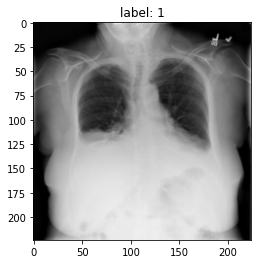

In [33]:
img = Image.open('/content/drive/My Drive/data/NIH/images-224/00001601_012.png').convert('RGB')
img_np = np.array(img)
plt.imshow(img_np)
plt.title("label: 1")

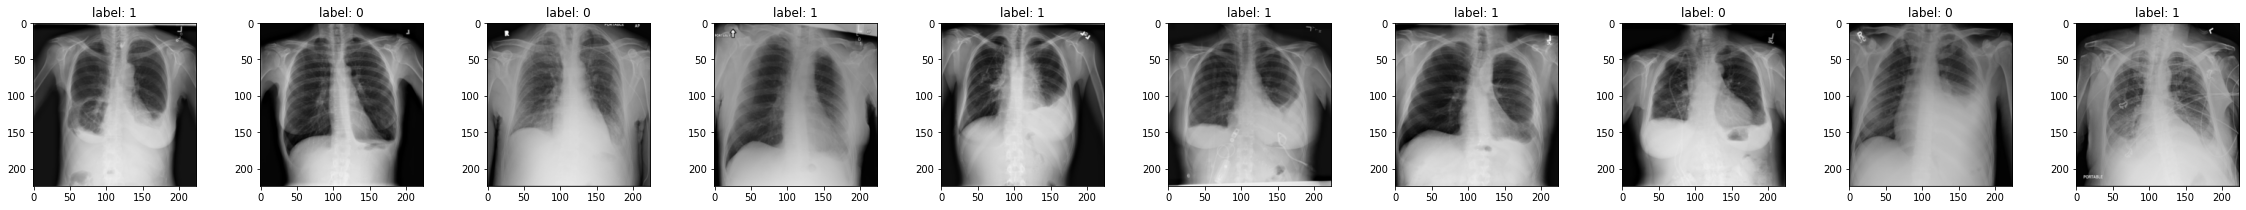

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=len(re_img), figsize=(40, 3))

for i, image in enumerate(re_img):
    img = Image.open(image).convert('RGB')
    img_np = np.array(img)
    axes[i].imshow(img_np)
    axes[i].set_title("label: {}".format(re_label[i]))
    
plt.show()
